# Libraries

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack, csr_matrix
import re
import nltk
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rashfiqurrahman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Loading the Data

In [6]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (1697533, 9)
Test shape: (212192, 2)


In [46]:
print(train_df.head)
print(test_df.head)

<bound method NDFrame.head of               Id   ProductId          UserId  HelpfulnessNumerator  \
0         914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1         354887  6303079709  A2I8RXJN80A2D2                     0   
2        1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3        1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4         475323  630574453X  A13NM1PES9OXVN                     2   
...          ...         ...             ...                   ...   
1697528   510697  B00001IVEC  A2GY7CJXS09779                     0   
1697529   230001  6300251330  A2B73CL3QSYWLB                     0   
1697530  1346402  B003IHUI0O  A1BOA9HRMEPLKX                     0   
1697531   695280  B000063JZ6  A1MHTHU9A6OFN3                     0   
1697532  1371294  B003Y58CLC   AOWNQQG5UHK9U                     3   

         HelpfulnessDenominator        Time  \
0                             2  1341014400   
1                             0  11

# Feature Engineering

In [7]:
# Sample 10% of the training data
train_sample = train_df.sample(frac=0.1, random_state=42)


def add_features_to(df):
    df['HelpfulnessDenominator'] = df['HelpfulnessDenominator'].replace(0, np.nan)
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
 
    df['Summary'] = df['Summary'].fillna('')
    df['Text'] = df['Text'].fillna('')

    df['Summary_length'] = df['Summary'].str.len()
    df['Text_length'] = df['Text'].str.len()

    return df

# Apply the function to the sampled train data and full test data
train_sample = add_features_to(train_sample)
train_sample.reset_index(drop=True, inplace=True)  # Reset index after sampling

# Since the test IDs correspond to missing 'Score' entries in train_df, we need to extract them
test_ids = test_df['Id'].unique()
test_data = train_df[train_df['Id'].isin(test_ids)].copy()
test_data = add_features_to(test_data)
test_data.reset_index(drop=True, inplace=True)

stop_words = set(stopwords.words('english'))


# Preprocessing

In [8]:
def preprocess_text_simple(text):
    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub('[^a-zA-Z]', ' ', text).lower()
    # Remove stop words
    words = [word for word in text.split() if word not in stop_words]
    # Join words back into one string
    return ' '.join(words)


train_sample['Combined_Text'] = train_sample['Summary'] + ' ' + train_sample['Text']
test_data['Combined_Text'] = test_data['Summary'] + ' ' + test_data['Text']
train_sample['Cleaned_Text'] = train_sample['Combined_Text'].apply(preprocess_text_simple)
test_data['Cleaned_Text'] = test_data['Combined_Text'].apply(preprocess_text_simple)


In [9]:
# Combine the data for vectorization
combined_cleaned_data = pd.concat([train_sample['Cleaned_Text'], test_data['Cleaned_Text']], axis=0)

# Initialize TF-IDF Vectorizer with reduced parameters
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# Fit and transform the combined text data
tfidf_combined_text = tfidf_vectorizer.fit_transform(combined_cleaned_data)

# Split the vectorized data back into train and test sets
tfidf_train = tfidf_combined_text[:len(train_sample)]
tfidf_test = tfidf_combined_text[len(train_sample):]

# List of numerical features
numeric_features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Helpfulness', 'Summary_length', 'Text_length']

# Prepare numeric features for training and testing data
X_train_numeric = train_sample[numeric_features].fillna(0).reset_index(drop=True)
X_test_numeric = test_data[numeric_features].fillna(0).reset_index(drop=True)

# Combine TF-IDF features with numeric features
X_train_combined = hstack([tfidf_train, csr_matrix(X_train_numeric.values)])
X_test_combined = hstack([tfidf_test, csr_matrix(X_test_numeric.values)])

# Define the target variable
y_train = train_sample['Score']

# Handling Class Imbalance

In [10]:
# Use class weights in Logistic Regression
class_weights = 'balanced'

# Model Building and Evaluation


In [20]:
# Split the training data into training and validation sets
X_train_part, X_valid, y_train_part, y_valid = train_test_split(
    X_train_combined, y_train, test_size=0.25, random_state=42)

# Define the parameter grid to search
param_grid = {
    'C': [1],
    'solver': ['liblinear'],
    'penalty': ['l2'],
    'l1_ratio': [0.5]
}

#best: 1, liblinear, l2

# Initialize the GridSearchCV
grid_search = GridSearchCV(
    LogisticRegression(max_iter=500, class_weight=class_weights),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

#getting rid of nulls
X_train_part = X_train_part[~y_train_part.isna()]
y_train_part = y_train_part[~y_train_part.isna()]

X_valid = X_valid[~y_valid.isna()]
y_valid = y_valid[~y_valid.isna()]

# Fit the model
grid_search.fit(X_train_part, y_train_part)

# Best parameters (i was able to train were C:1 , solver: liblinear, and penalty: l1)
print("Best parameters found: ", grid_search.best_params_)

# Best estimator
best_logreg = grid_search.best_estimator_

# Predict and evaluate
y_pred_logreg = best_logreg.predict(X_valid)
accuracy_logreg = accuracy_score(y_valid, y_pred_logreg)
print("Tuned Logistic Regression Accuracy:", accuracy_logreg)



/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Best parameters found:  {'C': 1, 'l1_ratio': 0.5, 'penalty': 'l2', 'solver': 'liblinear'}
Tuned Logistic Regression Accuracy: 0.6363587337539772


# Visualizations

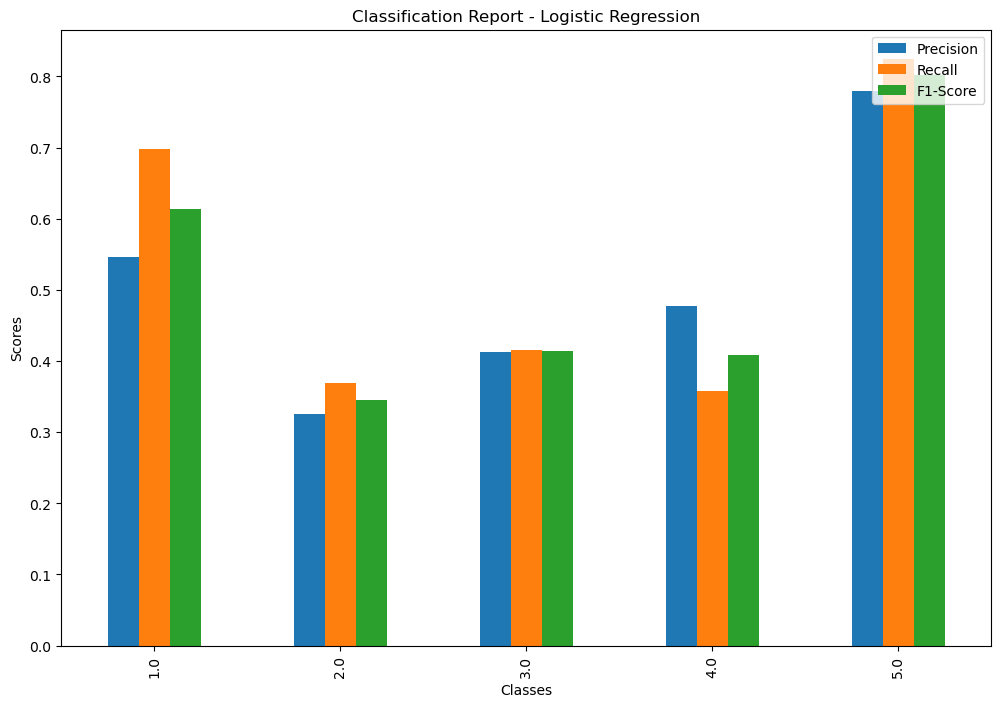

In [44]:

# 1. Classification Report as a DataFrame
class_report = classification_report(y_valid, y_pred_logreg, output_dict=True)
class_report_df = pd.DataFrame(class_report).transpose()

# Display classification report as a bar plot for Precision, Recall, F1-score for each class
class_report_df.iloc[:-3, :-1].plot(kind="bar", figsize=(12, 8))
plt.title("Classification Report - Logistic Regression")
plt.xlabel("Classes")
plt.ylabel("Scores")
plt.legend(["Precision", "Recall", "F1-Score"], loc="upper right")
plt.show()



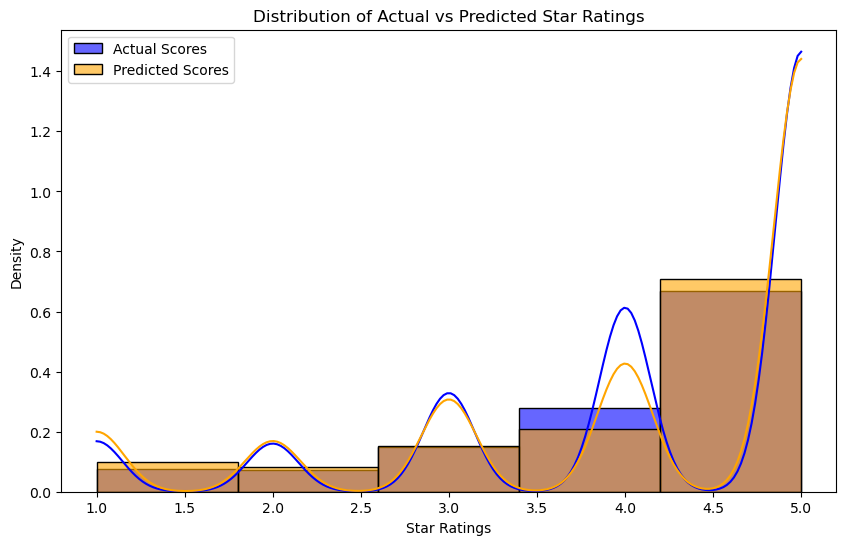

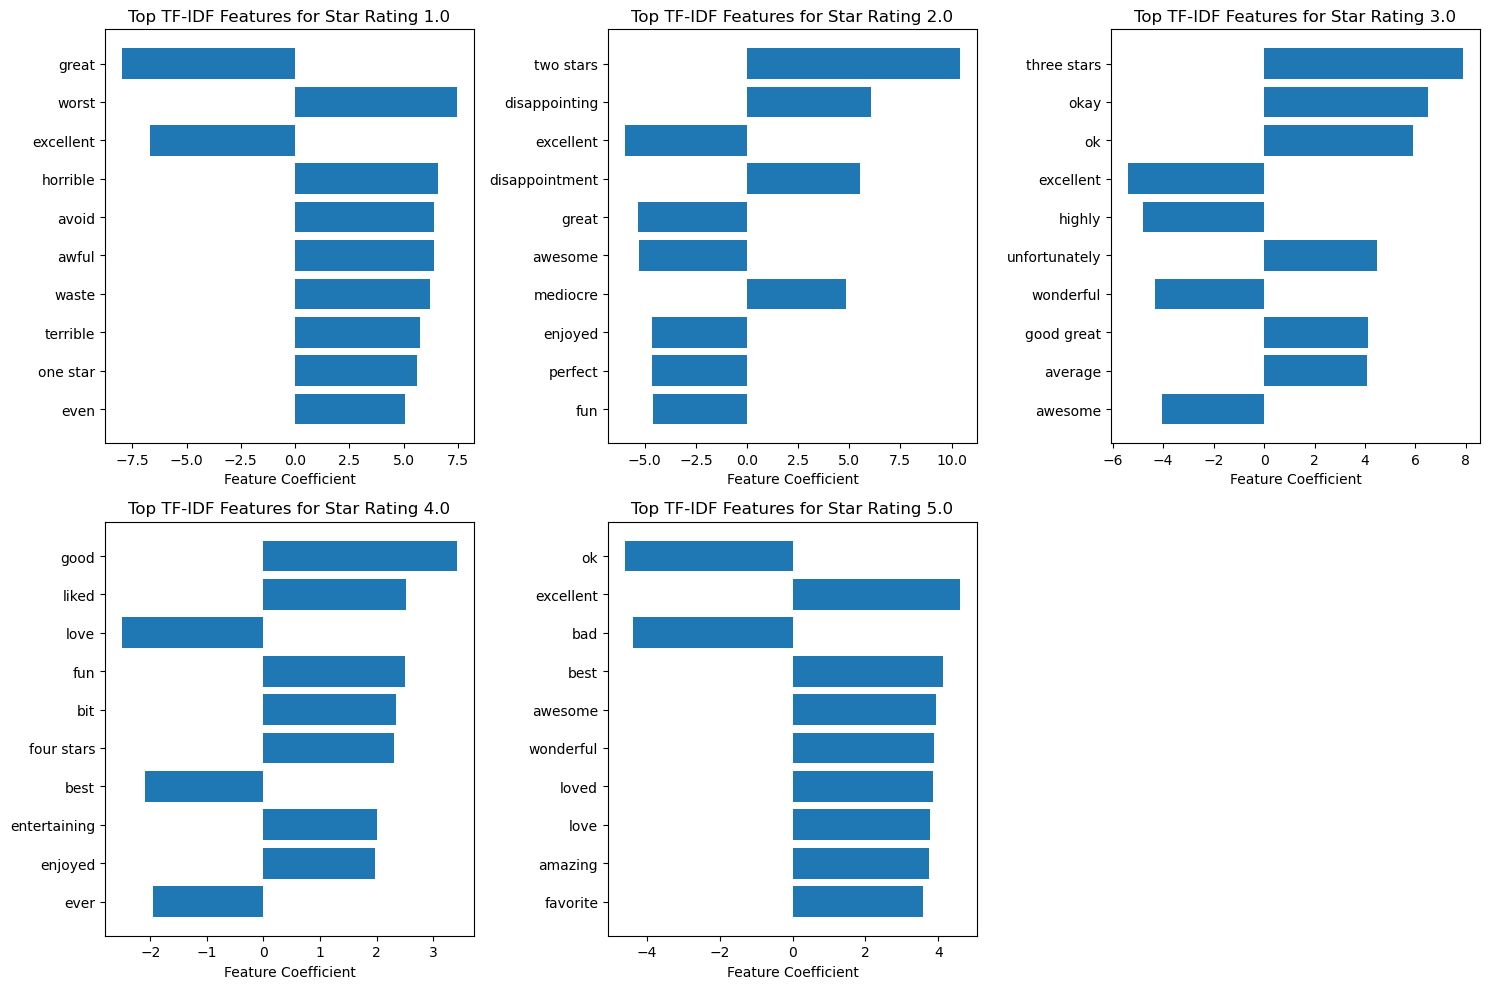

In [42]:

plt.figure(figsize=(10, 6))
sns.histplot(y_valid, color="blue", label="Actual Scores", kde=True, bins=5, stat="density", alpha=0.6)
sns.histplot(y_pred_logreg, color="orange", label="Predicted Scores", kde=True, bins=5, stat="density", alpha=0.6)
plt.xlabel("Star Ratings")
plt.ylabel("Density")
plt.title("Distribution of Actual vs Predicted Star Ratings")
plt.legend()
plt.show()

# Get the TF-IDF feature names and coefficients from the logistic regression model
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = best_logreg.coef_

# Top 10 features per class based on absolute values of coefficients
top_n = 10
plt.figure(figsize=(15, 10))

for i, class_label in enumerate(best_logreg.classes_):
    # Get top feature indices for each class
    top_indices = np.argsort(np.abs(coefficients[i]))[-top_n:]
    
    # Plot the top features for the current class
    plt.subplot(2, 3, i + 1)
    plt.barh([feature_names[idx] for idx in top_indices], coefficients[i][top_indices])
    plt.title(f'Top TF-IDF Features for Star Rating {class_label}')
    plt.xlabel("Feature Coefficient")
    plt.tight_layout()

plt.show()


# Creating Submission File

In [12]:
# Drop rows with NaN in y_train and the corresponding rows in X_train_combined
nan_mask = ~y_train.isna()
X_train_combined = X_train_combined[nan_mask]
y_train = y_train[nan_mask]
print(f"X_train_combined shape: {X_train_combined.shape}")
print(f"y_train shape: {y_train.shape}")

best_logreg.fit(X_train_combined, y_train)
y_test_pred = best_logreg.predict(X_test_combined)

submission = test_df[['Id']].copy()
submission['Score'] = y_test_pred

# Save to CSV
submission.to_csv('submission.csv', index=False)

print("Submission file created successfully!")


X_train_combined shape: (148342, 5005)
y_train shape: (148342,)
Submission file created successfully!
